# Imports and Defines

## Imports
    Imports all modules and submodules that were necessary in this study.
    Special mention to TimeSeriesCrossValidation which was created with the purpose to be used in this thesis.

In [1]:
import numpy as np
import pandas as pd
import xlsxwriter
import warnings
import matplotlib.pyplot as plt
import pandas_datareader as dr
import seaborn as sns

from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

# This python module was developed for this thesis
from TimeSeriesCrossValidation import splitTrain, splitTrainVal

%matplotlib inline

## Define Functions
    Defines helper functions

In [2]:
# Compute MAE over an array of different horizons
def horizonMAE(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[:i]), 2))
    return list_MAE;

In [3]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true) / y_true));

In [4]:
# Compute MAPE over an array of different horizons
def horizonMAPE(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true.T, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[:i]), 2))
        return list_MAPE;

In [5]:
# Revert diffLogSeries values to real scale values using initialValue (Diff(Log(x)) -> x)
def revertLogDiff(initialValue, diffLogSeries):
    original = initialValue
    #for i in np.arange(len(diffLogSeries)):
    #    original = np.append(original, original[-1]*(np.e**diffLogSeries[i]))
    for diffLogVal in diffLogSeries:
        original = np.append(original, original[-1]*(np.e**diffLogVal))
    return original[1:]

## Define Univariate Time-Series to study
    df: Dataframe with an index and a value column
    title: Title of data being used
    xlab: Label of df.index
    ylab: Label of df.values
    seasonal_periods: The repetition cycle
    
    stepsToForecast: Steps to forecast out-of-sample (and in-sample)

In [26]:
#stepsToForecast = [1, 3, 12];
#df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
#df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
#df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
#title = 'CPIAUC'
#xlab = 'Months/Year'; 
#ylab = 'Consumer Price Index';
#seasonal_periods = 12

stepsToForecast = [1, 5, 21];
df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
df = pd.DataFrame(df, columns= ['Date','Close'])
df.set_index('Date', drop=True, inplace=True)
df.index = pd.DatetimeIndex(df.index)
df = df.truncate(after='2019-09-28')
df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
title = 'PSI20: Historical Closing Prices'
xlab = 'Business Days/Year'; 
ylab = 'Closing Price (Euro)';
seasonal_periods = 5

#stepsToForecast = [1, 5, 21];
#df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'SP500'
#xlab = 'Business Days/Year'; 
#ylab = 'Closing Price (Dollar)';
#seasonal_periods=5;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
#df_train = df[['TRFVOLUSM227NFWA']][:-stepsToForecast[-1]].rename(columns={'TRFVOLUSM227NFWA': 'train'})
#df_test = df[['TRFVOLUSM227NFWA']][-stepsToForecast[-1]:].rename(columns={'TRFVOLUSM227NFWA': 'test'})
#title = "Vehicle Miles Traveled";
#xlab = "Months/Year";
#ylab = "Millions of Miles";
#seasonal_periods = 12

# Training Deep Neural Network

## Data Pre-Processing
    The options here include:
        - Slicing the data
        - Standardization or Normalization
        - Smoothing techniques
        - Stationarity techniques
        - Working with residuals

In [30]:
# Allows training data to be sliced
series_input = df_train.values[-7*12:].copy()
#series_input = df_train.values.copy()

series_input_bd = series_input # before diff
series_input = np.log(pd.DataFrame(series_input)).diff().dropna().values

## Visualization of Data Pre-Processed

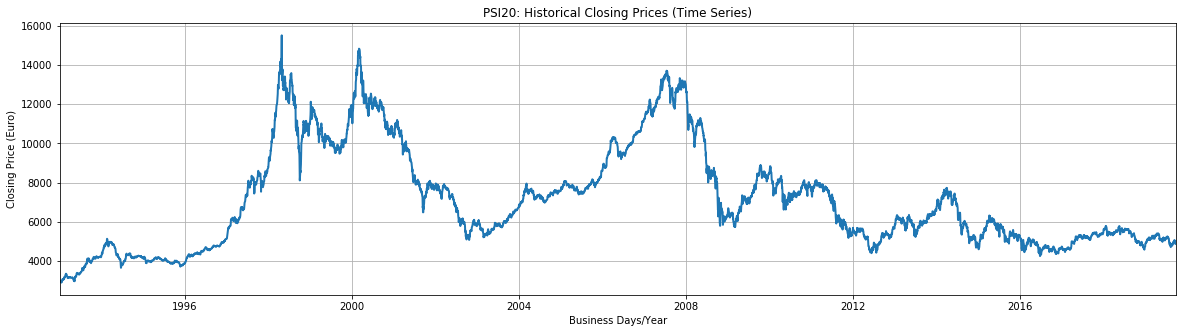

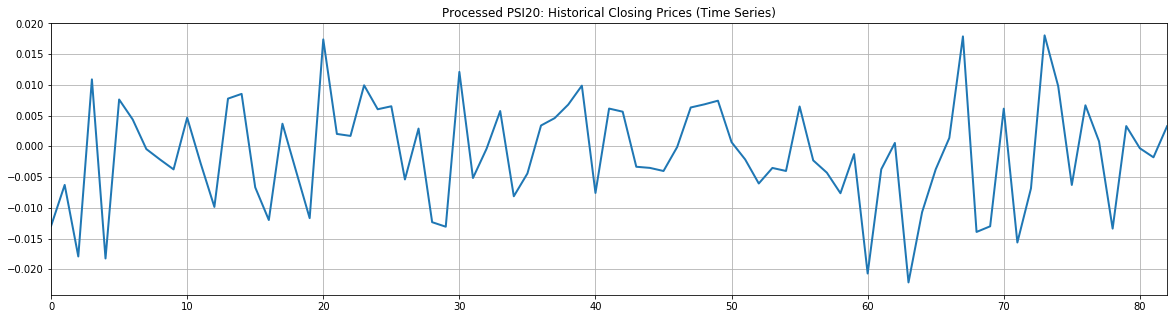

In [43]:
plt.figure(figsize=(20,5))
plt.plot(df.index, df.values, LineWidth=2)
plt.title(title + ' (Time Series)')
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.xlim([df.index[0], df.index[-1]])
plt.grid()

plt.figure(figsize=(20,5))
plt.plot(series_input, LineWidth=2)
plt.title('Processed ' + title + ' (Time Series)')
plt.grid()
plt.xlim(0, len(series_input)-1)
plt.show()

## Model Selection (tune hyper-parameters)
    In this work, the models to be used will be:
        - Multilayer Perceptron (MLP)
        - Recurrent Neural Network (RNN)
        - Long Short-Term Memory (LSTM)
        
    Where the tunable hyper-parameters are:
        Explicit:
            - n_steps_input: Number of samples to be fed to the ANN
            - n_steps_jump: Number of samples to jump in training (speed up technique)
            - train_epochs: Number of epochs for the model to train
        Implicit:
            - Number of layers
            - Number of neurons of EACH layer
            - Activation function of EACH layer
            - Dropout
            - Optimization algorithm and loss function used in training
        
    Note: n_steps_forecast is chosen a-priori.

In [26]:
# Select between 'MLP', or 'LSTM'
NN_str = 'LSTM'

n_steps_input = 10
n_steps_jump = 1

train_epochs = 50

model = Sequential()
if (NN_str == 'MLP'):
    model.add(Dense(50, activation='relu', input_dim=n_steps_input))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(stepsToForecast[-1], activation='linear'))
elif (NN_str == 'LSTM'):
    model.add(LSTM(10,input_shape=(n_steps_input, 1), activation='linear', return_sequences=True))  
    model.add(LSTM(25, activation='linear', return_sequences=True))
    model.add(LSTM(50, activation='linear', return_sequences=True))
    model.add(LSTM(30, activation='linear', return_sequences=True))
    model.add(LSTM(20, activation='linear', return_sequences=True))
    model.add(LSTM(15, activation='linear', return_sequences=False))
    model.add(Dense(stepsToForecast[-1], activation='linear'))
else:
    print("This model is not recognized.")

model.compile(optimizer='adam', loss='mae')

## Cross-Validation
    Aqui foi selecionado  a metogloda porque ....

### Compute Cross-Validation Errors

In [27]:
X_train, y_train, X_cv, y_cv = splitTrainVal \
    .split_train_val_groupKFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)

X_train_bd, y_train_bd, X_cv_bd, y_cv_bd = splitTrainVal \
    .split_train_val_groupKFold(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
    
dict_mae = {} 
for ix in np.arange(len(X_train)):
    
    print("%d/%d" % (ix+1, len(X_train)));
    
    if (NN_str == 'MLP'):
        X_train[ix] = np.squeeze(X_train[ix], axis=2)
        X_cv[ix] = np.squeeze(X_cv[ix], axis=2)
        X_train_bd[ix] = np.squeeze(X_train_bd[ix], axis=2)
        X_cv_bd[ix] = np.squeeze(X_cv_bd[ix], axis=2)
    y_train[ix] = np.squeeze(y_train[ix], axis=2)
    y_cv[ix] = np.squeeze(y_cv[ix], axis=2)
    y_train_bd[ix] = np.squeeze(y_train_bd[ix], axis=2)
    y_cv_bd[ix] = np.squeeze(y_cv_bd[ix], axis=2)
    
    ## ------- TRAINING MODEL -------
    model.fit(X_train[ix], y_train[ix], epochs = train_epochs, verbose = 0);
    
    ## ------- TRAINING ERROR -------
    y_pred_train_t = list()
    y_train_t = list()
    for i in np.arange(len(X_train[ix])):
        if (NN_str == 'LSTM'):
            y_pred_train_t.append(revertLogDiff(np.array([X_train_bd[ix][i][-1]]), \
                np.array(model.predict(X_train[ix][i].reshape(1, n_steps_input, 1))).tolist()[0]))
        else:
            y_pred_train_t.append(revertLogDiff(np.array([X_train_bd[ix][i][-1]]), \
                    np.array(model.predict(X_train[ix][i].reshape(1, n_steps_input))).tolist()[0]))
        y_train_t.append(revertLogDiff(np.array([y_train_bd[ix][i][0]]), y_train[ix][i]))
        
    list_mae_train = list()
    for i in np.arange(len(y_train_t)):
        mae_train = mean_absolute_error(y_train_t[i], y_pred_train_t[i])
        list_mae_train.append(mae_train)
        
    ## ------- CROSS VALIDATION ERROR -------
    y_pred_cv_t = list()
    y_cv_t = list()
    for i in np.arange(len(X_cv[ix])):
        if (NN_str == 'LSTM'):
            y_pred_cv_t.append(revertLogDiff(np.array([X_cv_bd[ix][i][-1]]), \
                    np.array(model.predict(X_cv[ix][i].reshape(1, n_steps_input, 1))).tolist()[0]))
        else:
            y_pred_cv_t.append(revertLogDiff(np.array([X_cv_bd[ix][i][-1]]), \
                    np.array(model.predict(X_cv[ix][i].reshape(1, n_steps_input))).tolist()[0]))
        y_cv_t.append(revertLogDiff(np.array([y_cv_bd[ix][i][0]]), y_cv[ix][i]))

    list_mae_cv = list()
    for i in np.arange(len(y_cv_t)):
        mae_cv = mean_absolute_error(y_cv_t[i], y_pred_cv_t[i])
        list_mae_cv.append(mae_cv)

    dict_mae[str(ix)] = {'train': list_mae_train, 'cv': list_mae_cv}
    
trainMae = np.mean([np.mean(dict_mae[str(runIx)]['train']) for runIx in np.arange(len(X_train))]);
cvMae = np.mean([np.mean(dict_mae[str(runIx)]['cv']) for runIx in np.arange(len(X_train))]);

1/5
2/5
3/5
4/5
5/5


### Cross-Validation Performance
    Assess Training / Cross-Validation / Test
    DEBUG_LEVEL = 0 - Only shows STATS of ALL runs
                  1 - Shows the average MAE through runs 
                  2 - Shows the MAE at each run at each train/cv/test set    

In [35]:
DEBUG_LEVEL = 0

print("STATS of ALL runs")    
print("Train avg MAE avg = %.4f" % trainMae) 
print("Cross-Validation avg MAE avg = %.4f" % cvMae)

list_train_mae = list()
list_cv_mae = list()
for runIx in np.arange(len(X_train)):
    if (DEBUG_LEVEL > 0):
        print("")
        print("----- RUN NUMBER %d -----" % (runIx+1))

    list_train_mae.append(np.mean(dict_mae[str(runIx)]['train']))
    if (DEBUG_LEVEL > 0):
        print ("Train MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['train'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['train'])>1):
                print("Individual trains: " + str([round(x,4) for x in dict_mae[str(runIx)]['train']]))
    
    list_cv_mae.append(np.mean(dict_mae[str(runIx)]['cv']))
    if (DEBUG_LEVEL > 0):
        print ("Cross-Validation MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['cv'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['cv'])>1):
                print("Individual cross-validations: " + str([round(x,4) for x in dict_mae[str(runIx)]['cv']]))

STATS of ALL runs
Train avg MAE avg = 0.0080
Cross-Validation avg MAE avg = 0.0082


### Cross-Validation Plot

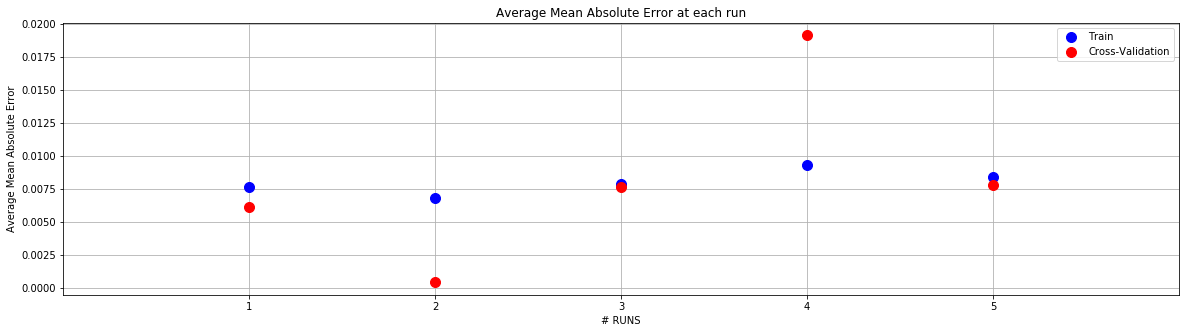

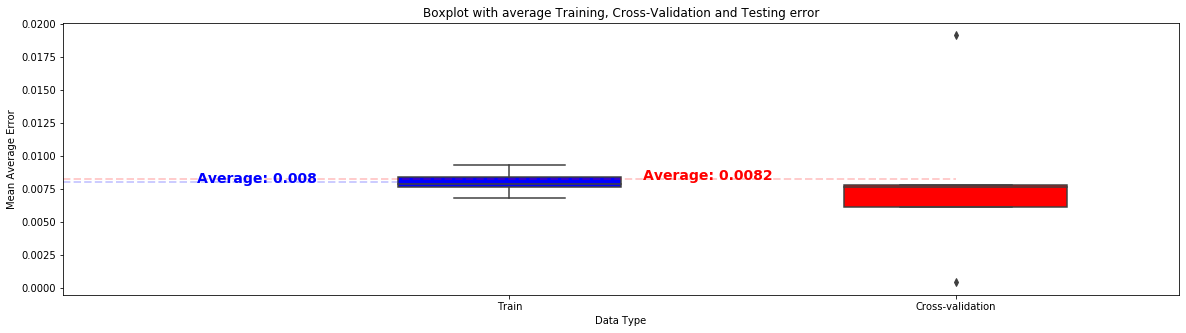

In [30]:
# Plot Mean Absolute Errors of each run
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(X_train))+1, list_train_mae, 'bo', markersize=10, label = 'Train')
plt.plot(np.arange(len(X_train))+1, list_cv_mae, 'ro', markersize=10, label = 'Cross-Validation')

plt.legend()
plt.xlabel('# RUNS')
plt.ylabel('Average Mean Absolute Error')
plt.title('Average Mean Absolute Error at each run')
if (len(X_train) > 500):
    plt.xticks(np.arange(0, len(X_train), 100))
if (len(X_train) > 250):
    plt.xticks(np.arange(0, len(X_train), 50))
elif (len(X_train) > 50):
    plt.xticks(np.arange(0, len(X_train), 10))
else:
    plt.xticks(np.arange(1,len(X_train)+1))
plt.xlim([0, len(X_train)+1])
plt.grid()

# Plot Mean Absolute Errors of each run
x_bp = np.concatenate((np.repeat('Train', len(list_train_mae)), \
                       np.repeat('Cross-validation', len(list_cv_mae))), axis = 0)
y_bp = np.concatenate((list_train_mae, list_cv_mae), axis = 0)

df_bp = pd.DataFrame(data={'Data Type': x_bp, 'Mean Average Error': y_bp})

plt.figure(figsize=(20, 5))
bplot=sns.boxplot(y='Mean Average Error', x='Data Type', data=df_bp, width=0.5)
bplot.artists[0].set_facecolor('blue')
bplot.artists[1].set_facecolor('red')
plt.title('Boxplot with average Training, Cross-Validation and Testing error');
plt.plot([-1,0], [trainMae, trainMae],'b--', lw=2, alpha=0.2)
plt.plot([-1,1], [cvMae, cvMae],'r--', lw=2, alpha=0.2)
plt.xlim([-1, 1.5])
plt.text(-0.70, 1*trainMae, 'Average: ' + str(round(trainMae,4)), fontsize=14, color='b', fontweight='bold')
plt.text(0.30, 1*cvMae, 'Average: ' + str(round(cvMae,4)), fontsize=14, color='r', fontweight='bold')

plt.show()

# Model forecasting

### Perform statistics on predictions
    This aims to run several predictions in order to have a stronger argument on predictions performance
    MAX_ITER corresponds to the amount of training & prediction used for statistics

In [13]:
MAX_ITER = 4

# This uses the entire training set to train
Xtest, ytest = splitTrain.split_train(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)

if (NN_str == 'MLP'):
    Xtest = np.squeeze(Xtest, axis=2)
ytest = np.squeeze(ytest, axis=2)

real_array = np.array(df_test.values).flatten()

i = 0
list_pred = list()
while (i < MAX_ITER):
    
    print("%d/%d" % (i+1, MAX_ITER));
    
    ## ------- TRAIN MODEL WITH ALL DATA-------
    model.fit(Xtest, ytest, epochs = train_epochs, verbose = 0);

    if (NN_str == 'MLP'):
        yhat = model.predict(series_input[-n_steps_input:].T, verbose=0)
        yhat_inSample = model.predict(series_input[-n_steps_input-stepsToForecast[-1]:-stepsToForecast[-1]].T, verbose=0)
    else:
        yhat = model.predict(series_input[-n_steps_input:].reshape(1, n_steps_input, 1), verbose=0)
        yhat_inSample = model.predict(series_input[-n_steps_input-stepsToForecast[-1]:-stepsToForecast[-1]].reshape(1, n_steps_input, 1), verbose=0)

    y_pred_test = yhat.tolist()
    y_pred_inSample = yhat_inSample.tolist()

    y_pred_test_t = revertLogDiff(df_train.values[-1], y_pred_test[0])
    y_pred_inSample_t = revertLogDiff(df_train.values[-stepsToForecast[-1]-1], y_pred_inSample[0])

    predictions_array = np.array(y_pred_test_t).flatten()
    predictions_inSample_array = np.array(y_pred_inSample_t).flatten()
    
    i = i + 1
    mae = horizonMAE(real_array, predictions_array, stepsToForecast)
    mape = horizonMAPE(real_array, predictions_array, stepsToForecast)
    list_pred.append((mae, mape, predictions_array, predictions_inSample_array))

1/4
2/4
3/4
4/4


###  Statistics cleaning
    This aims to extract the performance of our NN. For that we need to select PRED_OUTL and the forecast horizon that we are predicting for stepsToForecast(PRED_IX)
    PRED_OUTL corresponds to the number of predictions that are considered outliers
    PRED_IX corresponds to the number steps to forecast you want to organize your data

    Note that:
        - PRED_OUTL < MAX_ITER, with both being even numbers
        - The percentage considered as outlier is given by 100*(PRED_OUTL/MAX_ITER)
        - 1 < PRED_IX < len(stepsToForecast)

In [14]:
PRED_OUTL = 2
PRED_IX = 3

# Sorts elements based on longer term horizon
list_pred.sort(key=lambda elem: elem[0][PRED_IX-1])
list_pred_outlRemoved = list_pred[int(PRED_OUTL/2):-int(PRED_OUTL/2)]

print('The MAE(MAPE) with a horizon of ' + str(stepsToForecast[PRED_IX-1]) + ' samples for ' \
      + str(round(100-100*(PRED_OUTL/MAX_ITER),2)) + '% (' \
      + str(MAX_ITER-PRED_OUTL) + '\\' + str(MAX_ITER) + ') of runs is: \t'
      + str(list_pred_outlRemoved[0][0][PRED_IX-1]) + ' (' \
      + str(list_pred_outlRemoved[0][1][PRED_IX-1]) + '%) and ' \
      + str(list_pred_outlRemoved[-1][0][PRED_IX-1]) + ' (' \
      + str(list_pred_outlRemoved[-1][1][PRED_IX-1]) + '%)')

The MAE(MAPE) with a horizon of 21 samples for 50.0% (2\4) of runs is: 	229.61 (4.6%) and 245.21 (4.92%)


### Plot Prediction
    This will show the plot of, within the specified confidence interval, that perform the best prediction based on the horizon samples chosen (using PRED_IX above)
    This allows to understand what happens throughout the horizon forecast

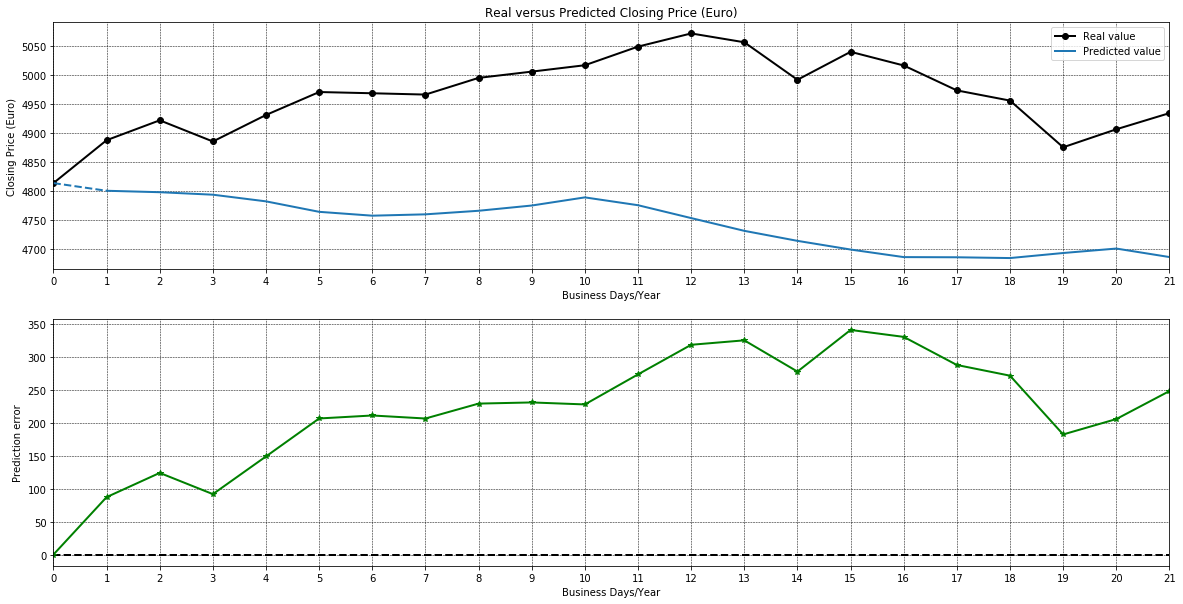

Prediction for 1 Business Days/Year: MAE = 87.13 (1.78%)
Prediction for 5 Business Days/Year: MAE = 131.59 (2.67%)
Prediction for 21 Business Days/Year: MAE = 229.61 (4.6%)


In [15]:
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab) 
plt.plot(range(0,len(real_array)+1), np.concatenate((df_train.values[-1], real_array), axis=0), 'k-o', linewidth=2)
plt.plot(range(1,len(predictions_array)+1), list_pred_outlRemoved[0][2], color = cmap(0), linewidth=2)
plt.plot([0,1], [df_train.values[-1][0], list_pred_outlRemoved[0][2][0]], '--', color = cmap(0), linewidth=2)

plt.xlim([0,len(predictions_array)])
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.plot(range(0,len(real_array-predictions_array)+1), np.concatenate((np.array([0]), real_array-list_pred_outlRemoved[0][2]), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.xlim([0,len(predictions_array)])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

for i in np.arange(len(stepsToForecast)):
    print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = '\
          + str(list_pred_outlRemoved[0][0][i]) + ' (' + str(list_pred_outlRemoved[0][1][i]) + '%)' )

### Plot Forecast in-sample vs out-sample
    This will show the plot of an in-sample vs an out-sample prediction, to understand how the NN is capable   to adapt to the seen data vs to generalize, respectively

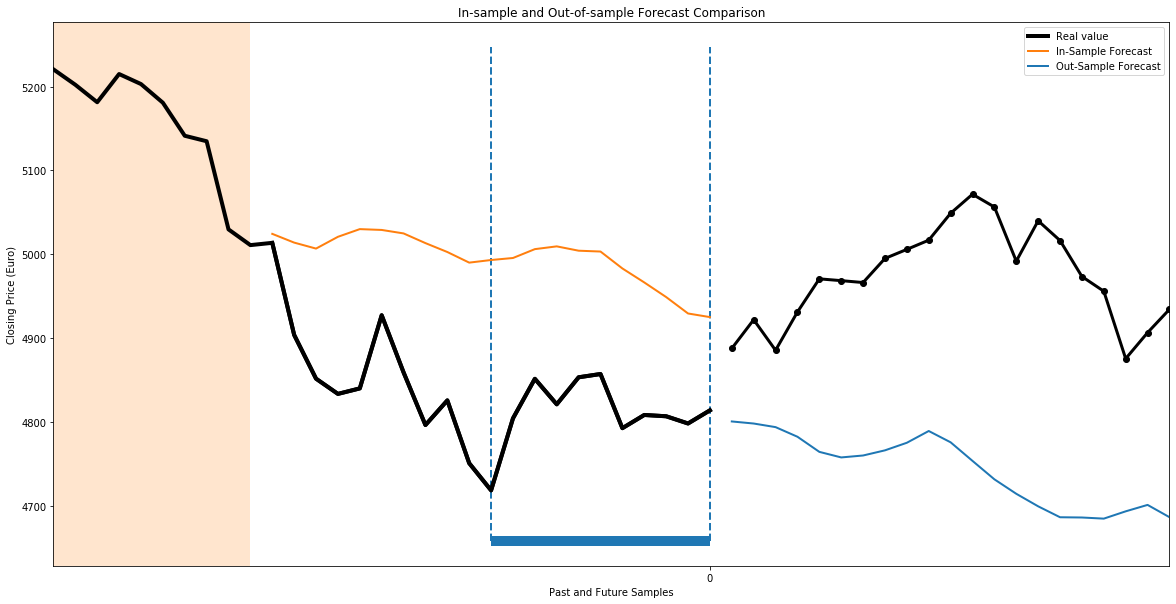

In [16]:
plt.figure(figsize=(20,10))
plt.title('In-sample and Out-of-sample Forecast Comparison') 
plt.plot(1+np.arange(stepsToForecast[-1])-stepsToForecast[-1], df_train.values[-stepsToForecast[-1]:], 'k', linewidth = 4)
plt.plot(1+np.arange(stepsToForecast[-1])-stepsToForecast[-1], list_pred_outlRemoved[0][3], color=cmap(1), linewidth = 2 )
plt.plot(range(1,len(predictions_array)+1), list_pred_outlRemoved[0][2], color=cmap(0), linewidth=2)
plt.legend(['Real value', 'In-Sample Forecast', 'Out-Sample Forecast'])
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3)
plt.plot(1+np.arange(stepsToForecast[-1]+n_steps_input)-stepsToForecast[-1]-n_steps_input, df_train.values[-n_steps_input-stepsToForecast[-1]:], 'k', linewidth = 4)

plt.xlim([1-stepsToForecast[-1]-n_steps_input,+stepsToForecast[-1]])
plt.xticks([0], '0')

plt.xlabel('Past and Future Samples')
plt.ylabel(ylab)

plt.axvspan(-stepsToForecast[-1]-n_steps_input, -stepsToForecast[-1], facecolor=cmap(1), alpha=0.2)
xmin, xmax, ymin, ymax = plt.axis()
plt.hlines(ymin, -n_steps_input, 0, colors=cmap(0), linewidth=10)
plt.vlines(-n_steps_input, ymin, ymax, colors=cmap(0), linewidth=2, linestyle='--')
plt.vlines(0, ymin, ymax, colors=cmap(0), linewidth=2, linestyle='--')
plt.show()

In [17]:
list_pred_outlRemoved[0][2]

array([4800.50053984, 4798.03209501, 4793.73242235, 4782.25167192,
       4764.22006799, 4757.57713833, 4759.8878806 , 4766.03761456,
       4775.08109068, 4789.10487383, 4775.61162403, 4753.43448075,
       4731.45284479, 4714.2038463 , 4699.24153161, 4686.20308054,
       4685.90358054, 4684.55819943, 4693.2608946 , 4700.93130267,
       4686.29204136])